uitleg knn -> werking: buren
uitleg decision-tree-regr -> alg uitleg

Data set:
    split in train + test
    uitleg cross-val (uit cursus) + extend naar time series

WARD:
KNN -> cross met train (gridsearch gedoe) -> geeft knn met beste params
repeat for decision tree regr

vgl test err op test set + plot

conclusie: x beter dan y in deze situatie ...




voorspellings lijn over de tijd van test set


how do x models compare to time series data:
concl: knn wrs shit

### 1.2.1 Training data description


The data contains 15000 measurements from the period: 01/11/2016 untill 24/04/2016. These are measurements of four months, of 105 different day. Each day contains 144 measure. This is one measure every ten minutes.

Below, a table can be seen that shows the data we are given. All the features contain numbers, except the feature "date" which is of the type datetime. This must be taken into consideration when feeding a model with this data. Not every model is can handle the datetime so we will adapt it.

| | Column | Data type |
| --- | --- | --- |
| 1  |  date |          datetime |
| 2  |  T1 - T9 |       float64 |
| 3  |  RH_1 - RH_9 |   float64 |
| 20 |  T_out |         float64 |
| 21 |  Press_mm_hg |   float64 |
| 22 |  RH_out |        float64 |
| 23 |  Windspeed |     float64 |
| 24 |  Visibility |    float64 |
| 25 |  Tdewpoint |     float64 |
| 26 |  rv1 |           float64 |
| 27 |  rv2 |           float64 |
| 28 |  lights |        int64 |
| 29 |  Appliances |    int64 | 

In [37]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [38]:
# Code copied from assignment from Fabian's previous course: Machine Learning
data_folder = "./data-rq-3/"

def load_data():
    return pd.read_csv(data_folder + "train.csv")


def split_date(data):
    # Some transformations to date that will be useful for visualizing and training     
    data['date'] = pd.to_datetime(data['date'])
    data['date-short'] = pd.to_datetime(data["date"].dt.strftime('%Y-%m-%d'))

    data['day'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%d'))
    data['month'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%m'))
    data['hour'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%H'))
    data['minute'] = pd.to_numeric(pd.to_datetime(data["date"]).dt.strftime('%M'))

    data['minute'] = data['minute'] // 10
    data['day'] = data['day'] - 1  # such that everything starts at 0
    data['month'] = data['month'] - 1  # 0 based

    return data


def select_features(data):
    return data[[
        "lights",
        "day",
        "month",
        "hour",
        "minute",
        "T1", "RH_1",
        "T2", "RH_2",
        "T3", "RH_3",
        "T4", "RH_4",
        "T5", "RH_5",
        "T6", "RH_6",
        "T7", "RH_7",
        "T8", "RH_8",
        "T9", "RH_9",
        "T_out", "Press_mm_hg",
        'RH_out',
        'Windspeed',
        'Visibility',
        'Tdewpoint'
        # We don't use the random-variable1 or 2
        # 'rv1',
        # 'rv2'
        #  Appliances of course isn't added either since that's what the model must predict
    ]]


def preprocess(data):
    data = split_date(data)

    xs = select_features(data)
    ys = data['Appliances']

    return xs, ys


def trainTestSplit(data):
    nsamples = data.shape[0]
    split = int(math.floor(0.8 * nsamples))  #use 80% of samples as training set

    data_train = data[0:split]
    data_test = data[split:nsamples]

    return data_train, data_test


def evaluate(y_true, y_pred):
    # calculate RMSE
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [39]:
# Code copied from assignment from Fabian's previous course: Machine Learning

# @Ward: best hier ff naar kijken of ik juiste xs/x_trains/... meegeef, 
# LAAT ME WETEN ALS IK FOUT BEN!!! IK WIL BIJLEREN :)
def trainAndTest(model, xs_train, ys_train, xs_test, ys_test):
    model_name = type(model()).__name__

    m = model()
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

    # part of training data is used for model selection (=validation set)
    scores = cross_val_score(m, xs_train, ys_train, cv=cv, scoring='neg_root_mean_squared_error')
    # TODO @Ward: find best arguments

    # after obtaining the best params, a model is trained on all training data
    reg = m.fit(xs_train, ys_train)

    print(model_name)
    print("RMSE (train): {}".format(evaluate(ys_train, reg.predict(xs_train))))
    print("RMSE (test): {}".format(evaluate(ys_test, reg.predict(xs_test))))
    print("Cross validation RMSE: {}".format(scores.mean()))

    return reg

In [40]:
data = load_data()
# first split data into two parts, s.t training data can be visualized without snooping into test data
train, test = trainTestSplit(data)
xs_train, ys_train = preprocess(train)
xs_test, ys_test = preprocess(test)

# Smaller sample for plotting, otherwise too much data, training will happen on all training data
sample = train[train['minute'] == 0]  # 2500 elements
# visualizations are only done on training data, not on test data

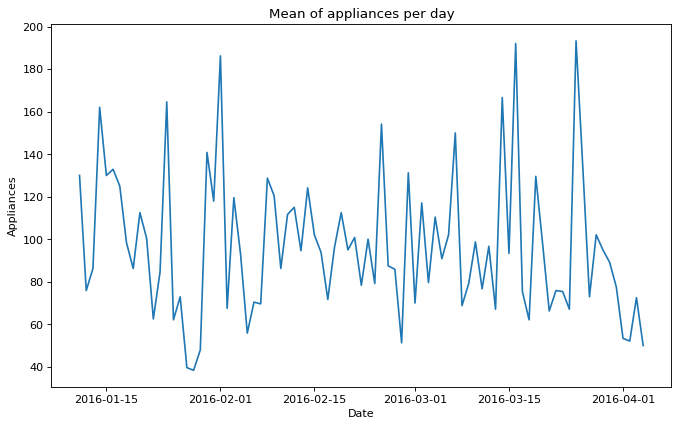

In [41]:
# Code copied from assignment from Fabian's previous course: Machine Learning

# Plot the mean of appliances per day
figure(figsize=(10, 6), dpi=80)

meanPerDay = sample.groupby('date-short', as_index=False)['Appliances'].mean()
plt.plot(meanPerDay['date-short'], meanPerDay['Appliances'])
plt.title("Mean of appliances per day")
plt.xlabel("Date")
plt.ylabel("Appliances")
plt.show()

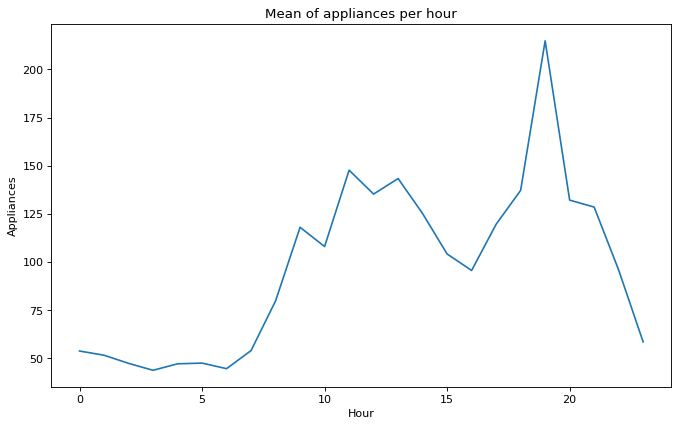

In [42]:
# Code copied from assignment from Fabian's previous course: Machine Learning

figure(figsize=(10, 6), dpi=80)

differentDates = sample['date-short'].unique()
# remove first day and and last day because those two days don't have measures of entire day
length = len(differentDates)
differentDates = differentDates[1: length - 1]

hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
appliances = []
for date in differentDates:
    oneDay = sample[sample['date-short'] == date]
    appliances.append(oneDay['Appliances'].values)

means = np.mean(appliances, axis=0)

plt.title("Mean of appliances per hour")
plt.xlabel("Hour")
plt.ylabel("Appliances")
plt.plot(hours, means)
plt.show()

In [43]:
from sklearn.tree import DecisionTreeRegressor

reg = trainAndTest(DecisionTreeRegressor, xs_train, ys_train, xs_test, ys_test)

DecisionTreeRegressor
RMSE (train): 0.0
RMSE (test): 153.82262512387442
Cross validation RMSE: -96.72563455873187


In [44]:
xs_test

,lights,day,month,hour,minute,T1,RH_1,T2,RH_2,T3,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
12000,0,3,3,1,0,21.926667,44.500000,20.666667,45.663333,23.000000,...,24.200000,50.326667,20.39,46.260000,14.8,748.500000,77.000000,5.000000,29.0,10.700000
12001,0,3,3,1,1,22.000000,44.500000,20.600000,45.663333,23.000000,...,24.200000,50.500000,20.39,46.326667,14.6,748.516667,78.000000,4.666667,29.0,10.716667
12002,0,3,3,1,2,21.926667,44.500000,20.600000,45.730000,23.000000,...,24.133333,50.500000,20.39,46.466667,14.4,748.533333,79.000000,4.333333,29.0,10.733333
12003,0,3,3,1,3,21.963333,44.500000,20.533333,45.790000,23.000000,...,24.066667,50.560000,20.39,46.766667,14.2,748.550000,80.000000,4.000000,29.0,10.750000
12004,0,3,3,1,4,21.890000,44.500000,20.500000,45.900000,23.000000,...,24.066667,50.693333,20.39,46.966667,14.0,748.566667,81.000000,3.666667,29.0,10.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,23,3,20,1,22.100000,35.760000,19.533333,37.400000,22.390000,...,24.356667,35.760000,20.29,33.030000,5.1,757.833333,73.666667,4.666667,40.0,0.700000
14996,10,23,3,20,2,22.033333,35.626667,19.500000,37.290000,22.426667,...,24.356667,35.700000,20.29,32.900000,4.9,757.866667,75.333333,4.333333,40.0,0.800000
14997,0,23,3,20,3,22.000000,35.466667,19.426667,37.290000,22.426667,...,24.390000,35.663333,20.29,32.826667,4.7,757.900000,77.000000,4.000000,40.0,0.900000
14998,0,23,3,20,4,22.000000,35.400000,19.356667,37.360000,22.390000,...,24.390000,35.663333,20.26,32.663333,4.5,757.933333,78.666667,3.666667,40.0,1.000000
